### Dogs vs Cats - Leveraging Pretrained Model
We've seen before, that our own convnet reached around 81% test accuracy, and could lifted to around 90% if we added more layers or more filters. But, to improve from that point would be difficult due to small amount of data we have. So, to obtain high accuracy on test data, we leverage pretrained models.

Let's first load our data into this, like before:

In [1]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# download data
! kaggle competitions download -c dogs-vs-cats
! unzip -qq dogs-vs-cats.zip
! unzip -qq train.zip

 98% 797M/812M [00:07<00:00, 182MB/s]
100% 812M/812M [00:07<00:00, 117MB/s]


In [3]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
print(original_dir)
print(new_base_dir)

train
cats_vs_dogs_small


In [4]:
def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames: shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [5]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Now, let's defined our model:

In [6]:
import tensorflow as tf
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Now, as in my notes, there are 2 methods. Let's see the first one:

In [8]:
import numpy as np

def get_features_and_labels(dataset):
	all_features = []
	all_labels = []
	for images, labels in dataset:
		preprocessed_images = keras.applications.vgg16.preprocess_input(images)
		features = conv_base.predict(preprocessed_images)
		all_features.append(features)
		all_labels.append(labels)
	return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


So, what is this doing? `predict()`  only expects images, not labels, but our current dataset yields batches that contain images and their labels. Moreover, the VGG16  model expects inputs that are pre-processed with the function `keras.applications.vgg16.preprocess_input`, which scales pixels to an appropriate range. Let’s see the shape of the extracted features:

In [9]:
train_features.shape

(2000, 5, 5, 512)

In [10]:
from keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
                     optimizer="rmsprop",
                     metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
       filepath="feature_extraction.keras",
       save_best_only=True,
       monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 11ms/step - loss: 20.4243 - accuracy: 0.9200 - val_loss: 4.0353 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 2.5230 - accuracy: 0.9765 - val_loss: 7.0702 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 3.3024 - accuracy: 0.9790 - val_loss: 5.4378 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2208 - accuracy: 0.9905 - val_loss: 4.9984 - val_accuracy: 0.9660
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.8929 - accuracy: 0.9905 - val_loss: 5.7974 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7321 - accuracy: 0.9950 - val_loss: 5.9639 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4129 - accuracy: 0.9950 - val_loss: 5.4763 - val_accuracy: 0.9740
Epoch 8/20
63/63 [

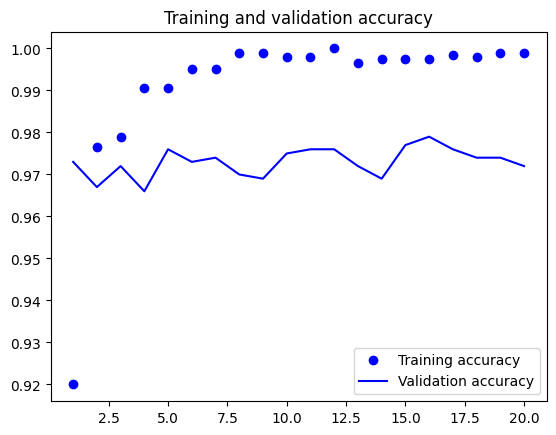

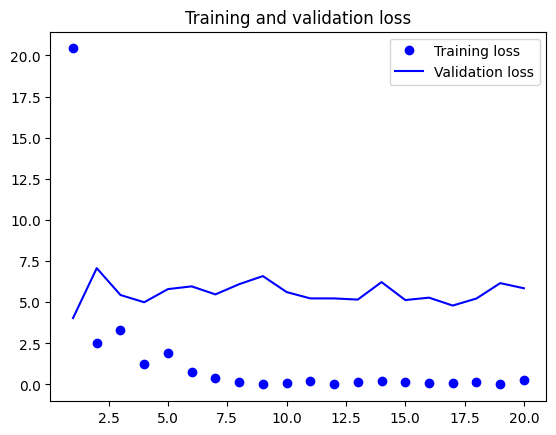

In [11]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.

Now, we look a the second method:

In [12]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
] )
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# x = keras.applications.vgg16.preprocess_input(x).  -> this is a bug, not working
x = keras.layers.Lambda(
    lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 12s 150ms/step - loss: 17.2169 - accuracy: 0.9020 - val_loss: 3.6051 - val_accuracy: 0.9720
Epoch 2/50
63/63 [==============================] - 9s 137ms/step - loss: 6.1655 - accuracy: 0.9485 - val_loss: 9.5224 - val_accuracy: 0.9530
Epoch 3/50
63/63 [==============================] - 9s 146ms/step - loss: 6.6523 - accuracy: 0.9560 - val_loss: 4.3870 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 9s 139ms/step - loss: 4.1638 - accuracy: 0.9635 - val_loss: 4.8130 - val_accuracy: 0.9750
Epoch 5/50
63/63 [==============================] - 10s 149ms/step - loss: 3.2896 - accuracy: 0.9730 - val_loss: 7.5407 - val_accuracy: 0.9630
Epoch 6/50
63/63 [==============================] - 9s 142ms/step - loss: 4.2474 - accuracy: 0.9675 - val_loss: 4.9577 - val_accuracy: 0.9680
Epoch 7/50
63/63 [==============================] - 10s 146ms/step - loss: 3.8833 - accuracy: 0.9695 - val_loss: 7.4803 - val_accuracy: 0.9670
Ep

Let's test the accuracy:

In [15]:
test_model = keras.models.load_model(
            "feature_extraction_with_data_augmentation.keras",
            safe_mode=False)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 6s 94ms/step - loss: 1.6271 - accuracy: 0.9785
Test accuracy: 0.979


So, we arrive at a test accruacy of 97.3%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data.

Another commonly used technique for using pre-trained models, complementary to feature extraction, is fine-tuning. Let's see this below (notes for details on ths in my Notion)

In [16]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 212ms/step - loss: 0.5290 - accuracy: 0.9870 - val_loss: 1.5805 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 11s 176ms/step - loss: 0.3059 - accuracy: 0.9910 - val_loss: 1.5342 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 11s 170ms/step - loss: 0.5235 - accuracy: 0.9890 - val_loss: 1.6658 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 12s 193ms/step - loss: 0.1726 - accuracy: 0.9935 - val_loss: 1.7051 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 11s 178ms/step - loss: 0.3106 - accuracy: 0.9915 - val_loss: 1.3385 - val_accuracy: 0.9810
Epoch 6/30
63/63 [==============================] - 11s 166ms/step - loss: 0.1522 - accuracy: 0.9935 - val_loss: 1.6253 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 10s 161ms/step - loss: 0.2119 - accuracy: 0.9920 - val_loss: 1.7577 - val_accuracy: 0.9830

In [19]:
model = keras.models.load_model("fine_tuning.keras", safe_mode=False)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 91ms/step - loss: 1.4733 - accuracy: 0.9795
Test accuracy: 0.979
